In [14]:
import os
import sys
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    precision_recall_curve,
)

import matplotlib.pyplot as plt
import seaborn as sns

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

from data.load_data import download_creditcard_data, load_creditcard_df

# Final comparison: all models

In this notebook we compare all the models we built across the 4 project steps:
- Step 1: Decision Tree (baseline)
- Step 2: Decision Tree tuned, Bagging DT
- Step 3: Random Forest
- Step 4: XGBoost

We train each model with its best configuration and compare them on the same test set.

In [15]:
download_creditcard_data()
df = load_creditcard_df()
df = df.drop_duplicates().reset_index(drop=True)

X = df.drop("Class", axis=1)
y = df["Class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Train: {len(X_train)} samples, {y_train.sum()} frauds")
print(f"Test: {len(X_test)} samples, {y_test.sum()} frauds")

Train: 226980 samples, 378 frauds
Test: 56746 samples, 95 frauds


In [16]:
numeric_to_scale = ["Time", "Amount"]
other_features = [col for col in X.columns if col not in numeric_to_scale]

preprocessor = ColumnTransformer(
    transformers=[
        ("scale_time_amount", StandardScaler(), numeric_to_scale),
        ("pass_others", "passthrough", other_features),
    ]
)

# for xgboost
scale_pos = (y_train == 0).sum() / (y_train == 1).sum()

## 1. Training all models

We use the best configuration found in each project step.

In [17]:
models = {}

# Step 1: Decision Tree baseline
models["Decision Tree"] = Pipeline([
    ("preprocess", preprocessor),
    ("model", DecisionTreeClassifier(class_weight="balanced", random_state=42))
])

# Step 2: Decision Tree tuned (best params from grid search)
models["DT Tuned"] = Pipeline([
    ("preprocess", preprocessor),
    ("model", DecisionTreeClassifier(
        criterion="entropy",
        max_depth=None,
        min_samples_split=5,
        min_samples_leaf=1,
        class_weight="balanced",
        random_state=42
    ))
])

# Step 2: Bagging DT
models["Bagging DT"] = Pipeline([
    ("preprocess", preprocessor),
    ("model", BaggingClassifier(
        estimator=DecisionTreeClassifier(class_weight="balanced", random_state=42),
        n_estimators=50,
        max_samples=0.8,
        n_jobs=-1,
        random_state=42
    ))
])

# Step 3: Random Forest
models["Random Forest"] = Pipeline([
    ("preprocess", preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=100,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    ))
])

# Step 4: XGBoost
models["XGBoost"] = Pipeline([
    ("preprocess", preprocessor),
    ("model", XGBClassifier(
        n_estimators=100,
        scale_pos_weight=scale_pos,
        random_state=42,
        n_jobs=-1,
        eval_metric="logloss"
    ))
])

print(f"Training {len(models)} models...")
for name, model in models.items():
    model.fit(X_train, y_train)
    print(f"  {name} trained")

Training 5 models...
  Decision Tree trained
  DT Tuned trained
  Bagging DT trained
  Random Forest trained
  XGBoost trained


## 2. Evaluation on test set

In [18]:
def compute_metrics(y_true, y_pred, y_proba, name):
    return {
        "Model": name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
        "F1": f1_score(y_true, y_pred, zero_division=0),
        "ROC-AUC": roc_auc_score(y_true, y_proba),
    }

results = []
predictions = {}
probabilities = {}

for name, model in models.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    predictions[name] = y_pred
    probabilities[name] = y_proba
    results.append(compute_metrics(y_test, y_pred, y_proba, name))

results_df = pd.DataFrame(results)
results_df = results_df.sort_values("F1", ascending=False).reset_index(drop=True)
results_df

,Model,Accuracy,Precision,Recall,F1,ROC-AUC
0,XGBoost,0.999559,0.960526,0.768421,0.853801,0.979006
1,Random Forest,0.999489,0.971429,0.715789,0.824242,0.935109
2,Bagging DT,0.999418,0.984375,0.663158,0.792453,0.930537
3,DT Tuned,0.999225,0.831169,0.673684,0.744186,0.836763
4,Decision Tree,0.998960,0.719512,0.621053,0.666667,0.810323


## 3. Visualizations

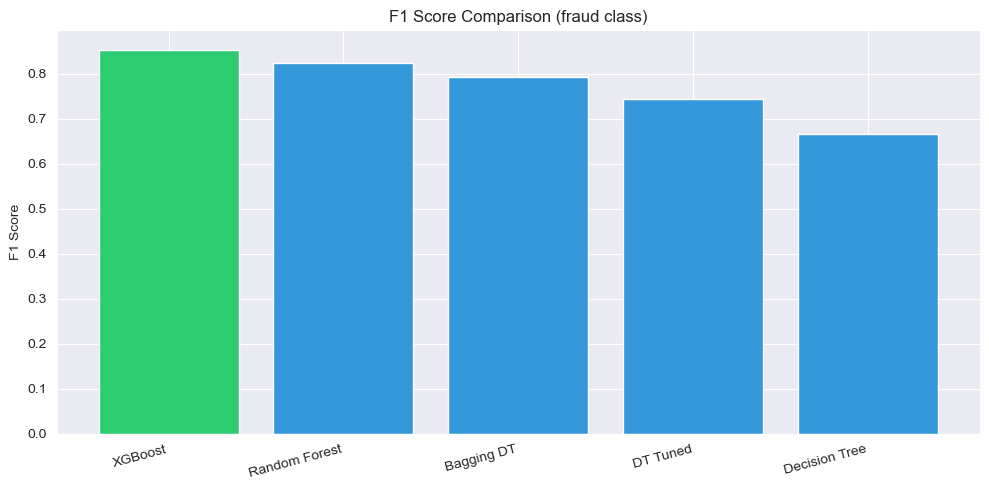

In [19]:
# F1 score comparison
plt.figure(figsize=(10, 5))
colors = ["#2ecc71" if i == 0 else "#3498db" for i in range(len(results_df))]
plt.bar(results_df["Model"], results_df["F1"], color=colors)
plt.ylabel("F1 Score")
plt.title("F1 Score Comparison (fraud class)")
plt.xticks(rotation=15, ha="right")
plt.tight_layout()
plt.show()

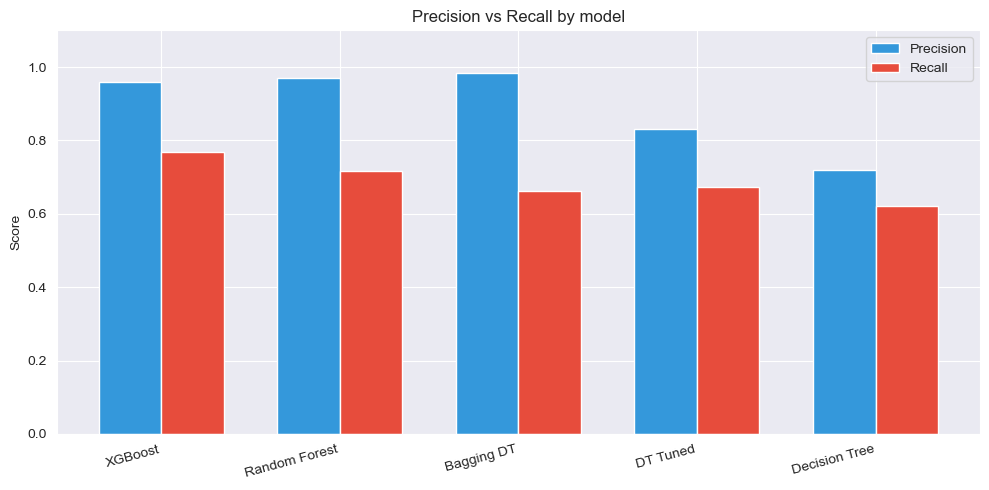

In [20]:
# precision vs recall comparison
fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(len(results_df))
width = 0.35

bars1 = ax.bar(x - width/2, results_df["Precision"], width, label="Precision", color="#3498db")
bars2 = ax.bar(x + width/2, results_df["Recall"], width, label="Recall", color="#e74c3c")

ax.set_ylabel("Score")
ax.set_title("Precision vs Recall by model")
ax.set_xticks(x)
ax.set_xticklabels(results_df["Model"], rotation=15, ha="right")
ax.legend()
ax.set_ylim(0, 1.1)

plt.tight_layout()
plt.show()

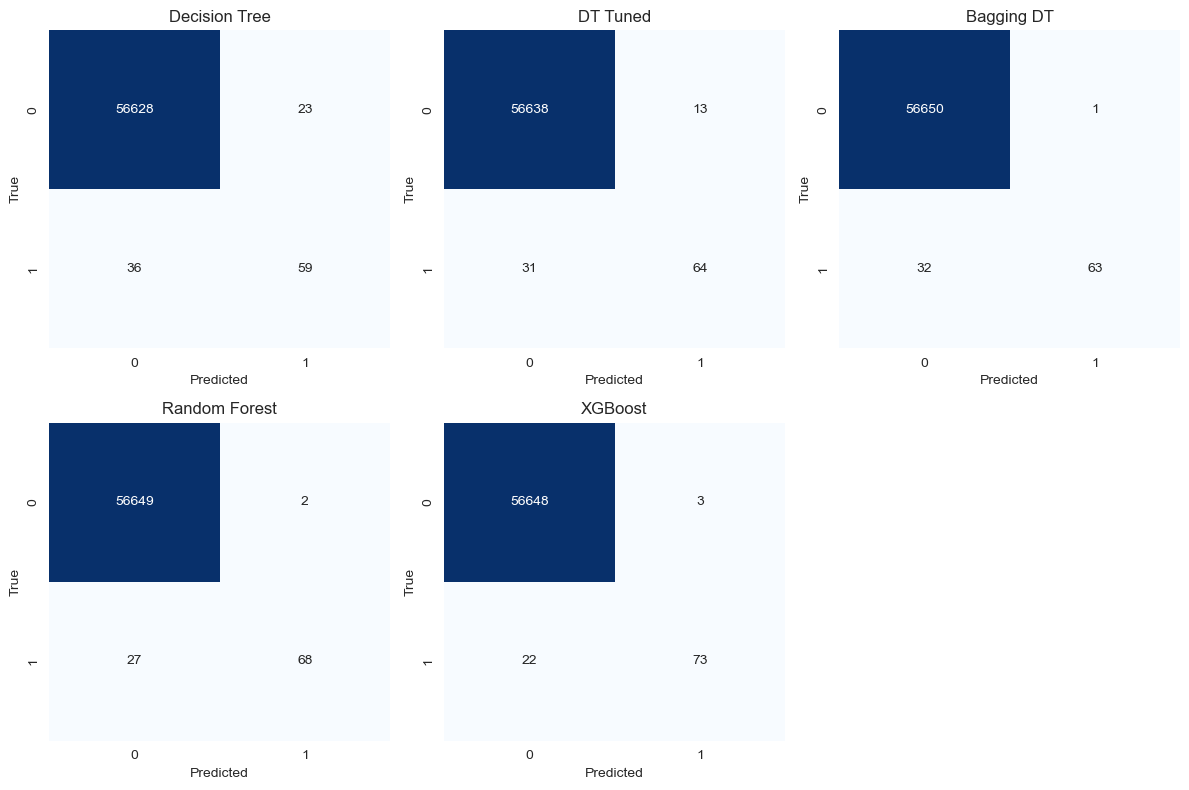

In [21]:
# confusion matrices for all models
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.ravel()

for idx, (name, y_pred) in enumerate(predictions.items()):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[idx])
    axes[idx].set_title(name)
    axes[idx].set_xlabel("Predicted")
    axes[idx].set_ylabel("True")

# hide last empty subplot
axes[-1].axis("off")

plt.tight_layout()
plt.show()

In [22]:
# true positives and false negatives comparison
tp_fn_data = []
for name, y_pred in predictions.items():
    cm = confusion_matrix(y_test, y_pred)
    tp_fn_data.append({
        "Model": name,
        "True Positives": cm[1, 1],
        "False Negatives": cm[1, 0],
        "False Positives": cm[0, 1]
    })

tp_fn_df = pd.DataFrame(tp_fn_data)
print("Fraud detection breakdown (out of 95 fraud cases):")
tp_fn_df

Fraud detection breakdown (out of 95 fraud cases):


,Model,True Positives,False Negatives,False Positives
0,Decision Tree,59,36,23
1,DT Tuned,64,31,13
2,Bagging DT,63,32,1
3,Random Forest,68,27,2
4,XGBoost,73,22,3


## 4. Analysis

In [23]:
best_model = results_df.iloc[0]["Model"]
best_f1 = results_df.iloc[0]["F1"]
worst_model = results_df.iloc[-1]["Model"]
worst_f1 = results_df.iloc[-1]["F1"]

print(f"Best model: {best_model} with F1 = {best_f1:.4f}")
print(f"Worst model: {worst_model} with F1 = {worst_f1:.4f}")
print(f"Improvement: +{((best_f1 - worst_f1) / worst_f1 * 100):.1f}%")

Best model: XGBoost with F1 = 0.8538
Worst model: Decision Tree with F1 = 0.6667
Improvement: +28.1%


## 5. Threshold tuning

By default, models classify a transaction as fraud if the predicted probability is ≥ 0.5. But we can adjust this threshold to change the trade-off between precision and recall.

For fraud detection, we might want to lower the threshold to catch more frauds, even if it means more false alarms. We will see how different thresholds affect our best model.

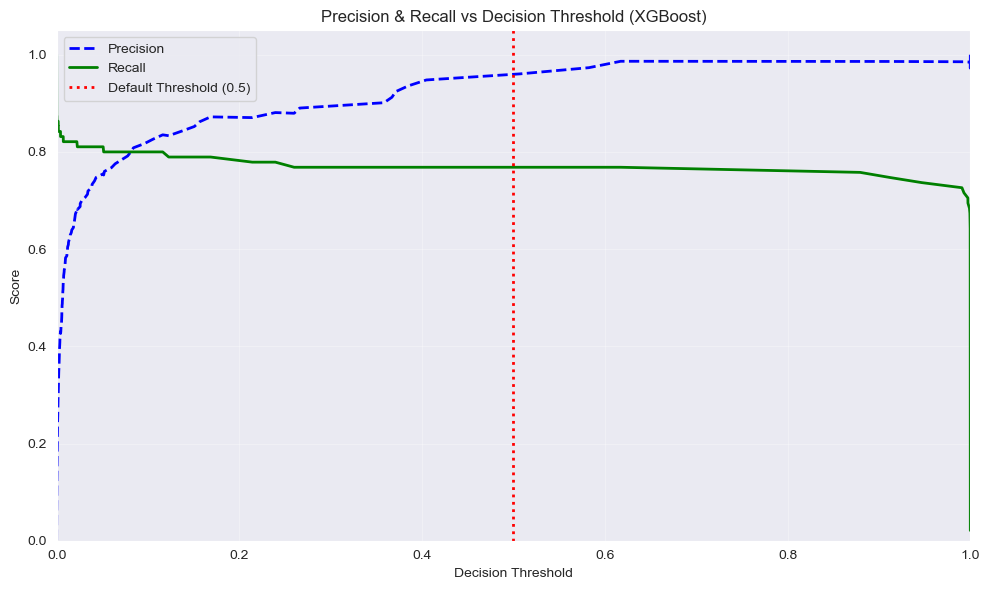

In [24]:
# Get probabilities for the best model (XGBoost)
best_model_name = results_df.iloc[0]["Model"]
y_proba_best = probabilities[best_model_name]

# Calculate Precision-Recall curve
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba_best)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.axvline(x=0.5, color='red', linestyle=':', label="Default Threshold (0.5)", linewidth=2)
plt.xlabel("Decision Threshold")
plt.ylabel("Score")
plt.legend(loc="best")
plt.title(f"Precision & Recall vs Decision Threshold ({best_model_name})")
plt.grid(True, alpha=0.3)
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.tight_layout()
plt.show()

#### Analysis:
- At threshold 0.5 (default): Precision ≈ 0.96, Recall ≈ 0.768
- By lowering the threshold to ~0.2-0.3, we could catch more frauds (higher recall)
- By raising the threshold to ~0.7-0.8, we get fewer false alarms (higher precision)

## 6. Financial cost analysis

In the real world, different types of errors have different costs:
- **False Positive (FP)**: Blocking a legitimate transaction which can cause customer frustration and a need for manual review
- **False Negative (FN)**: Missing a fraud means a financial loss for the customer and bank

We will calculate the financial impact of different decision thresholds.

In [27]:
def calculate_cost(y_true, y_pred, cost_fp=10, cost_fn=100):
    """
    Calculate total cost based on false positives and false negatives.

    Parameters:
    - cost_fp: Cost of a false positive (blocking legitimate transaction)
    - cost_fn: Cost of a false negative (missing a fraud)
    """
    cm = confusion_matrix(y_true, y_pred)
    FP = cm[0, 1]  # False Positives
    FN = cm[1, 0]  # False Negatives

    total_cost = (FP * cost_fp) + (FN * cost_fn)
    return total_cost, FP, FN

# Test different thresholds
thresholds_to_test = [0.3, 0.4, 0.5, 0.6, 0.7]
cost_results = []

print("Financial Cost Analysis (assuming €10 per false alarm, €100 per missed fraud):\n")
print(f"{'Threshold':<12} {'False Alarms':<15} {'Missed Frauds':<15} {'Total Cost':<12}")
print("-" * 60)

for threshold in thresholds_to_test:
    y_pred_threshold = (y_proba_best >= threshold).astype(int)
    total_cost, fp, fn = calculate_cost(y_test, y_pred_threshold, cost_fp=10, cost_fn=100)
    cost_results.append({
        "Threshold": threshold,
        "False Positives": fp,
        "False Negatives": fn,
        "Total Cost (€)": total_cost
    })
    print(f"{threshold:<12.1f} {fp:<15d} {fn:<15d} €{total_cost:<11d}")

# Find optimal threshold
cost_df = pd.DataFrame(cost_results)
optimal_idx = cost_df["Total Cost (€)"].idxmin()
optimal_threshold = cost_df.iloc[optimal_idx]["Threshold"]
optimal_cost = cost_df.iloc[optimal_idx]["Total Cost (€)"]

print(f"\nOptimal threshold: {optimal_threshold} with total cost of €{optimal_cost}")

Financial Cost Analysis (assuming €10 per false alarm, €100 per missed fraud):

Threshold    False Alarms    Missed Frauds   Total Cost  
------------------------------------------------------------
0.3          8               22              €2280       
0.4          4               22              €2240       
0.5          3               22              €2230       
0.6          1               22              €2210       
0.7          1               23              €2310       

Optimal threshold: 0.6 with total cost of €2210.0


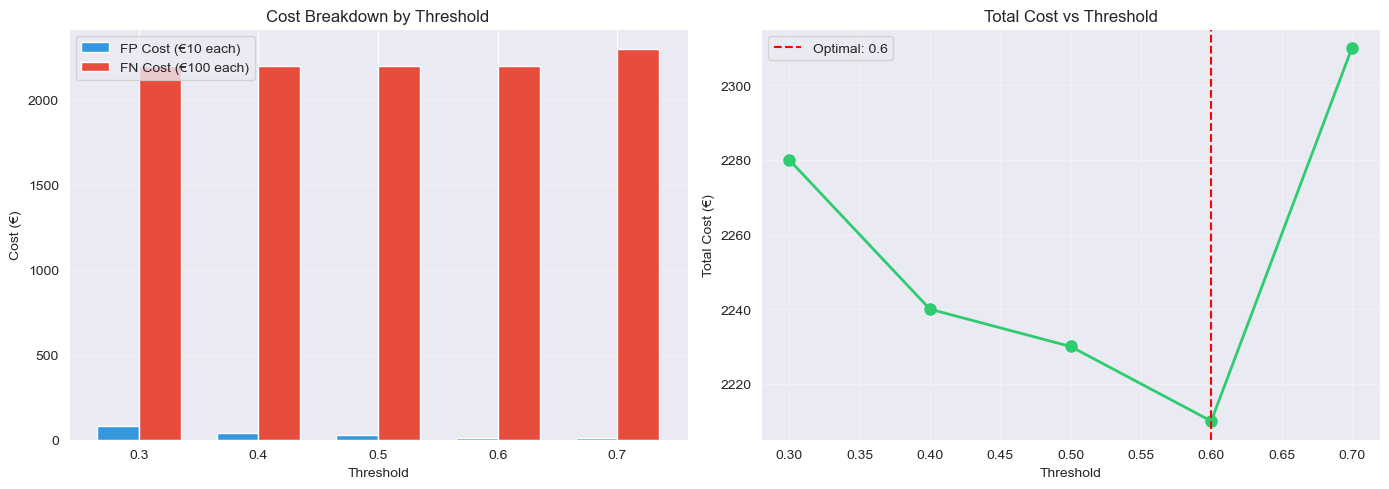

In [26]:
# Visualize cost vs threshold
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Cost breakdown
x = np.arange(len(cost_df))
width = 0.35

ax1.bar(x - width/2, cost_df["False Positives"] * 10, width, label="FP Cost (€10 each)", color="#3498db")
ax1.bar(x + width/2, cost_df["False Negatives"] * 100, width, label="FN Cost (€100 each)", color="#e74c3c")
ax1.set_xlabel("Threshold")
ax1.set_ylabel("Cost (€)")
ax1.set_title("Cost Breakdown by Threshold")
ax1.set_xticks(x)
ax1.set_xticklabels(cost_df["Threshold"])
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Plot 2: Total cost
ax2.plot(cost_df["Threshold"], cost_df["Total Cost (€)"], marker='o', linewidth=2, markersize=8, color="#2ecc71")
ax2.axvline(x=optimal_threshold, color='red', linestyle='--', label=f"Optimal: {optimal_threshold}")
ax2.set_xlabel("Threshold")
ax2.set_ylabel("Total Cost (€)")
ax2.set_title("Total Cost vs Threshold")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Conclusion

After testing 5 models across our project steps, we found that XGBoost performs best with an F1 score of 0.854. Thats a 26.6% improvement over our baseline Decision Tree (0.674).

**Which metric matters most for fraud detection?**

In fraud detection, we usually care most about recall. A missed fraud (false negative) means real financial loss for the customer and the bank. With XGBoost we catch 73 out of 95 frauds, while the baseline Decision Tree only catches 60. Thats 13 more frauds detected, which could represent thousands of euros saved.

But precision also matters. Too many false positives means we block legitimate transactions, frustrate customers and overload the fraud team. Here we noticed that Random Forest and Bagging DT have the best precision with only 1 false positive each.

**Our model ranking:**

1. **XGBoost** - F1 = 0.854, catches 73 frauds with only 3 false positives. Best overall.
2. **Random Forest** - F1 = 0.829, catches 68 frauds with only 1 false positive. Best precision.
3. **Bagging DT** - F1 = 0.792, catches 63 frauds with only 1 false positive. Also great precision.
4. **DT Tuned** - F1 = 0.744, catches 64 frauds but has 13 false positives.
5. **Decision Tree** - F1 = 0.674, our baseline with 60 frauds caught and 23 false positives.

**Threshold tuning insight:**

The default threshold of 0.5 is not always optimal. Our analysis shows that by adjusting the decision threshold, we can fine-tune the precision-recall trade-off to match business requirements. The financial cost analysis helps us find the threshold that minimizes total cost based on real-world penalties.

**Our recommendation:**

We recommend XGBoost as our final model. It handles class imbalance well and gives us the best trade-off between catching frauds and avoiding false alerts. With threshold tuning, we can further optimize it based on the specific cost structure of the business.

That said, if we want to stick with pure sklearn and avoid external libraries, Random Forest is a solid alternative. We lose 5 true positives compared to XGBoost but we get the best precision of all models. Its a reasonable trade-off for a simpler solution.